In [27]:
'''
 Load data. Input files defined in yaml files (destest_bpz.yaml, destest_metacal.yaml,destest_gold.yaml)
 It requires destest : 
 https://github.com/des-science/destest
 
 catalogs (to be specified in the yaml files):
 
 Latest version '/global/cscratch1/sd/troxel/cats_des_y3/Y3_mastercat_v2_6_20_18.h5'
 Latest subsampled version (for quick tests): '/global/cscratch1/sd/troxel/cats_des_y3/Y3_mastercat_v2_6_20_18_subsampled.h5'
 
 I didn't manage to run the destest Calibrator. This means that if you directly load R1 and R2 from the catalog,
 they are only the respones of the sample and neglect the response of the selection (which is usually few %).
 The solution I got was to load the columns without selection (uncut=True)
 and apply the response and selection by myself.
'''


from multiprocessing import Pool,sharedctypes
from functools import partial
from contextlib import closing


import matplotlib.pyplot as plt
import numpy as np
import pyfits as pf
import healpy as hp
import h5py as h5

import os
import sys

import sys
#sys.path.insert(0, '/global/homes/m/mgatti/Mass_Mapping/systematic_checks/')
sys.path.insert(0, '/global/homes/m/mgatti/Cosmic_Shear/ABE/')
from routines import *
import numpy as np

import yaml
param_file = './destest_metacal.yaml'


# ******************************************************************
#                              INPUT
# ******************************************************************
nside = 1024  



# output folders ***************
fold1= '/global/cscratch1/sd/mgatti/Cosmic_shear/output_ABE_mastercat_04_20/'  
name_folder_x = '/global/cscratch1/sd/mgatti/Cosmic_shear/output_ABE_mastercat_04_20/final/'

if not os.path.exists(fold1):
    os.mkdir(fold1)
if not os.path.exists(name_folder_x):
    os.mkdir(name_folder_x)

print ("done")

done


# Load catalog with destest

In [7]:
import yaml
import destest
import treecorr


# basic dict props
destest_dict_ = {
    'output_exists' : True,
    'use_mpi'       : False,
    'source'        : 'hdf5',
    'dg'            : 0.01
    }

# Populates a full destest yaml dict for each catalog selection based on the limited catalog input info provided in the common cats.yaml file
def create_destest_yaml( params, name, cal_type, group, table, select_path ):
    """
    Creates the input dictionary structure from a passed dictionary rather than reading froma yaml file.
    """

    destest_dict = destest_dict_.copy()
    destest_dict['load_cache'] = params['load_cache']
    destest_dict['output'] = params['output']
    destest_dict['name'] = name
    destest_dict['filename'] = params['datafile']
    destest_dict['param_file'] = params['param_file']
    destest_dict['cal_type'] = cal_type
    destest_dict['group'] = group
    destest_dict['table'] = table
    destest_dict['select_path'] = select_path
    destest_dict['e'] = ['e_1','e_2']
    destest_dict['Rg'] = ['R11','R22']
    destest_dict['w'] = 'weight'

    return destest_dict

# Build selector (and calibrator) classes from destest for the catalog.
def load_catalog(pipe_params, name, cal_type, group, table, select_path, inherit=None, return_calibrator=None):
    """
    Loads data access and calibration classes from destest for a given yaml setup file.
    """

    # Input yaml file defining catalog
    params = create_destest_yaml(pipe_params, name, cal_type, group, table, select_path)

    # Load destest source class to manage access to file
    source = destest.H5Source(params)

    # Load destest selector class to manage access to data in a structured way
    if inherit is None:
        sel = destest.Selector(params,source)
    else:
        sel = destest.Selector(params,source,inherit=inherit)

    # Load destest calibrator class to manage calibration of the catalog
    if return_calibrator is not None:
        cal = return_calibrator(params,sel)
        return sel, cal
    else:
        return sel

# Read yaml file that defines all the catalog selections used
params = yaml.load(open('cats.yaml'))
params['param_file'] = 'cats.yaml'

# Source catalog
source_selector, source_calibrator = load_catalog(
    params, 'mcal', 'mcal', params['source_group'], params['source_table'], params['source_path'], return_calibrator=destest.MetaCalib)

# Gold catalog
gold_selector = load_catalog(
    params, 'gold', 'mcal', params['gold_group'], params['gold_table'], params['gold_path'], inherit=source_selector)
# BPZ (or DNF) catalog, depending on paths in cats.yaml file (exchange bpz and dnf)
pz_selector = load_catalog(
    params, 'pz', 'mcal', params['pz_group'], params['pz_table'], params['pz_path'], inherit=source_selector)

'''
# Redmagic catalog
lens_selector, lens_calibrator = load_catalog(
    params, 'rm', None, params['lens_group'], params['lens_table'], params['lens_path'], return_calibrator=destest.NoCalib)

# Mag lim catalog
alt_lens_selector, alt_lens_calibrator = load_catalog(
    params, 'maglim', None, params['alt_lens_group'], params['alt_lens_table'], params['alt_lens_path'], return_calibrator=destest.NoCalib)



# Redmagic random catalog
ran_selector = load_catalog(
    params, 'ran', None, params['ran_group'], params['ran_table'], params['ran_path'])



# Get some source photo-z binning information, cut to range 0.1<z_mean<1.3                                                  
for i in range(1):
    print (i)
    pzbin = pz_selector.get_col('bhat') # 5-tuple for metacal (un)sheared versions                                         
    mask = [pzbin[j] == i for j in range(5)] # First tomographic bin                                                               
    # Note that get_col() returns a tuple. If its a catalog like gold, it will have length 0, but for something like metacal, it will have length 5 (in the order of the table variable list passed in cats.yaml, i.e., 'unsheared', 'sheared_1p', 'sheared_1m', 'sheared_2p', 'sheared_2m')                                                               
    # Note that get_col() applies the index mask specified by the 'path' variable in the cats.yaml file automatically.         # Get responses (c, which doesn't exist for our catalogs), and weights                                                      
    R1,c,w = source_calibrator.calibrate('e_1', mask=mask,return_full_w=True) # Optionally pass an additional mask to use when calculating the selection response. The returned R1 is <Rg_1 + Rs_1>. To get an array of R's, use return_wRg=True to get [Rg_1+Rg_2]/2 for each object or return_wRgS=True to include the selection response. return_full=True returns the non-component-averaged version of the full response.
    print len(w)
    #R2,c,w = source_calibrator.calibrate('e_2', mask=mask)
    #print(R2,c,w)
    
    g1=source_selector.get_col('e_1')[0]
    print(len(w),len(g1[0][mask[0]]))
    
    wa = source_calibrator.calibrate('e_1', mask=mask,return_full_w=True,weight_only=True) # Optionally pass an additional mask to use when calculating the selection response. The returned R1 is <Rg_1 + Rs_1>. To get an array of R's, use return_wRg=True to get [Rg_1+Rg_2]/2 for each object or return_wRgS=True to include the selection response. return_full=True returns the non-component-averaged version of the full response.
    print (len(wa))
   
    #g2=source_selector.get_col('e_2')[0]



'''
R1,c,w = source_calibrator.calibrate('e_1') # Optionally pass an additional mask to use when calculating the selection response. The returned R1 is <Rg_1 + Rs_1>. To get an array of R's, use return_wRg=True to get [Rg_1+Rg_2]/2 for each object or return_wRgS=True to include the selection response. return_full=True returns the non-component-averaged version of the full response.
print(R1,c,w)
R2,c,w = source_calibrator.calibrate('e_2')
print(R2,c,w)


# Load ra,dec from gold catalog
ra  = gold_selector.get_col('ra')[0]
dec = gold_selector.get_col('dec')[0]

# Get e1,e2 
g1=source_selector.get_col('e_1')[0]
g2=source_selector.get_col('e_2')[0]



w = source_calibrator.calibrate('e_1',weight_only=True) # Optionally pass an additional mask to use when calculating the selection response. The returned R1 is <Rg_1 + Rs_1>. To get an array of R's, use return_wRg=True to get [Rg_1+Rg_2]/2 for each object or return_wRgS=True to include the selection response. return_full=True returns the non-component-averaged version of the full response.

g1 =(g1 - np.mean(g1*w)/np.mean(w))/R1
g2 =(g2 - np.mean(g2*w)/np.mean(w))/R2

cat = dict()
cat[0] = [g1,g2, ra,dec,1]
print len(g1),len(ra)

'''
# Load ra,dec from redmagic catalog
ra  = lens_selector.get_col('ra')[0]
dec = lens_selector.get_col('dec')[0]
ra2  = ran_selector.get_col('ra')[0]
dec2 = ran_selector.get_col('dec')[0]


pz_selector = load_catalog(
        params, 'pzdnf', None, params['dnf_group'], params['dnf_table'], params['dnf_path'], inherit=alt_lens_selector)
'''

/global/u2/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/ipykernel_launcher.py:62: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


[u'T', u'T_err', u'covmat_0_1', u'covmat_1_1', u'covmat_2_2', u'e_1', u'e_2', u'flux_err_i', u'flux_err_r', u'flux_err_z', u'flux_i', u'flux_r', u'flux_z', u'size_ratio', u'snr', u'weight']
using select_path for mask
destest /global/cscratch1/sd/troxel/cats_des_y3/Y3_mastercat_03_31_20.h5 index/select 399263026 100202538
end mask [     7390      7391      7393 ... 399243228 399243235 399243240] [ True  True  True ...  True  True  True]
R11 not in sheared cols
R11 not in sheared cols
R11 not in sheared cols
R11 not in sheared cols
R22 not in sheared cols
R22 not in sheared cols
R22 not in sheared cols
R22 not in sheared cols
skipping sheared columns for e_1
skipping sheared columns for e_1
skipping sheared columns for e_1
skipping sheared columns for e_1
skipping sheared columns for e_2
skipping sheared columns for e_2
skipping sheared columns for e_2
skipping sheared columns for e_2
[u'bhat', u'cell_wide']
100202538
----- e_1 ['e_1', 'e_2']
100202538
init
100202538
100204688
after
Rs e

"\n# Load ra,dec from redmagic catalog\nra  = lens_selector.get_col('ra')[0]\ndec = lens_selector.get_col('dec')[0]\nra2  = ran_selector.get_col('ra')[0]\ndec2 = ran_selector.get_col('dec')[0]\n\n\npz_selector = load_catalog(\n        params, 'pzdnf', None, params['dnf_group'], params['dnf_table'], params['dnf_path'], inherit=alt_lens_selector)\n"

# load catalog (without destest)

In [ ]:
# read File *******
File_data = "/project/projectdirs/des/www/y3_cats/Y3_mastercat_03_31_20.h5"
master = h5.File(File_data,'r')

# load selections ********************************
select  = np.array(master['index']['select']) # gold + mcal
select_1p  = np.array(master['index']['select_1p'])
select_1m  = np.array(master['index']['select_1m'])
select_2p  = np.array(master['index']['select_2p'])
select_2m  = np.array(master['index']['select_2m'])

# load weights *************************************
w = np.array(master['catalog']['metacal']['unsheared']['weight'])
w1p = np.array(master['catalog']['metacal']['sheared_1p']['weight'])
w2p = np.array(master['catalog']['metacal']['sheared_1m']['weight'])
w1m = np.array(master['catalog']['metacal']['sheared_2p']['weight'])
w2m = np.array(master['catalog']['metacal']['sheared_2m']['weight'])

snr = np.array(master['catalog']['metacal']['unsheared']['snr'])
size_ratio =  np.array(master['catalog']['metacal']['unsheared']['size_ratio'])

ra_master = np.array(master['catalog']['metacal']['unsheared']['ra'])
dec_master =  np.array(master['catalog']['metacal']['unsheared']['dec'])

e1 = np.array(master['catalog']['metacal']['unsheared']['e_1'])#[select_all]
e2 = np.array(master['catalog']['metacal']['unsheared']['e_2'])#[select_all]
e1p = np.array(master['catalog']['metacal']['sheared_1p']['e_1'])#[select_metacal]
e1m = np.array(master['catalog']['metacal']['sheared_1m']['e_1'])#[select_metacal]
e2p = np.array(master['catalog']['metacal']['sheared_2p']['e_2'])#[select_metacal]
e2m = np.array(master['catalog']['metacal']['sheared_2m']['e_2'])#[select_metacal]
w = np.array(master['catalog']['metacal']['unsheared']['weight'])



# compute response weighted *************: 
dgamma = 2. * 0.01
R11_1_metacal_w = (np.sum((w1p*e1p)[select])/np.sum((w1p)[select])
                   - np.sum((w1m*e1m)[select])/np.sum((w1m)[select]) + 
                   np.sum((e1*w)[select_1p])/np.sum(w[select_1p]) -
                   np.sum((e1*w)[select_1m])/np.sum((w)[select_1m]))/ dgamma
R22_1_metacal_w = (np.sum((w2p*e2p)[select])/np.sum((w2p)[select])
                   - np.sum((w2m*e2m)[select])/np.sum((w2m)[select]) + 
                   np.sum((e2*w)[select_2p])/np.sum(w[select_2p]) -
                   np.sum((e2*w)[select_2m])/np.sum((w)[select_2m]))/ dgamma

print R11_1_metacal_w
print R22_1_metacal_w


g1 = np.array(master['catalog']['metacal']['unsheared']['e_1'])[select]/R11_1
g2 = np.array(master['catalog']['metacal']['unsheared']['e_2'])[select]/R22_1
ra = ra_master[select_metacal]
dec = dec_master[select_metacal]

cat = dict()
cat[0] = [g1,g2, ra,dec,1]
print len(g1),len(ra)

# Load stars

In [18]:
%matplotlib inline
# Load reserved stars and make grids
path_qq = "/global/homes/m/mjarvis/desdata/users/mjarvis/y3a1-v29/psf_y3a1-v29.fits"
output = "/global/cscratch1/sd/mgatti/Cosmic_shear/shape_systematics/"



prova =  field_methods()
fact = 0.05703422

mute11 = pf.open(path_qq)
dd_qq = mute11[1].data

bb = mute11[1].data['band'] 
mag = mute11[1].data['mag'] 
maks=((bb =='i') | (bb =='r') | (bb =='z')) & (mag<20)

ras  = mute11[1].data['ra'][maks]
decs  = mute11[1].data['dec'][maks]
p1  = mute11[1].data['obs_e1'][maks]
p2  = mute11[1].data['obs_e2'][maks]
q1  = (mute11[1].data['obs_e1']-mute11[1].data['piff_e1'])[maks]
q2  = (mute11[1].data['obs_e2']-mute11[1].data['piff_e2'])[maks]
w1  = (mute11[1].data['piff_e1']*((mute11[1].data['obs_T ']-mute11[1].data['piff_T'])/mute11[1].data['obs_T']))[maks]
w2  = (mute11[1].data['piff_e2']*((mute11[1].data['obs_T ']-mute11[1].data['piff_T'])/mute11[1].data['obs_T']))[maks]



print "done"


mean_rho_y3 = {'0': np.mean(p1)**2+np.mean(p2)**2,
               '1': np.mean(q1)**2+np.mean(q2)**2,
               '2': np.mean(q1)*np.mean(p1)+np.mean(p2)*np.mean(q2),
               '3': np.mean(w1)**2+np.mean(w2)**2,
               '4': np.mean(w1)*np.mean(q1)+np.mean(w2)*np.mean(q2),
               '5': np.mean(w1)*np.mean(p1)+np.mean(w2)*np.mean(p2),
               't0': np.mean(g1)*np.mean(p1)+np.mean(g2)*np.mean(p2),
               't1': np.mean(g1)*np.mean(q1)+np.mean(g2)*np.mean(q2),
               't2': np.mean(g1)*np.mean(w1)+np.mean(g2)*np.mean(w2)}

for key in mean_rho_y3.keys():
    mean_rho_y3[key] = np.sqrt(mean_rho_y3[key]**2)  
    
    


done


# weights for the stars

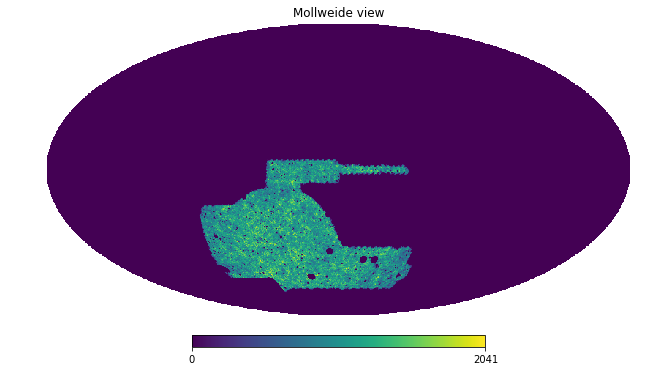

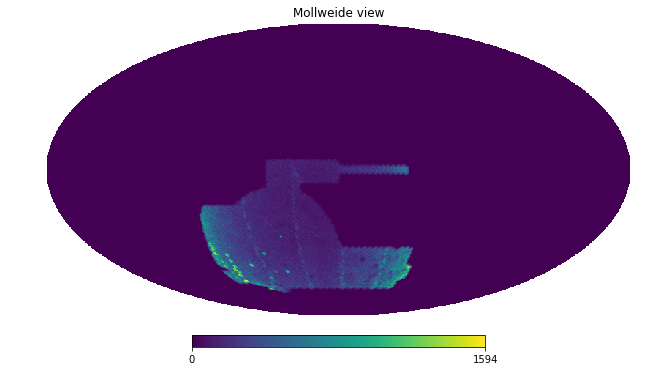

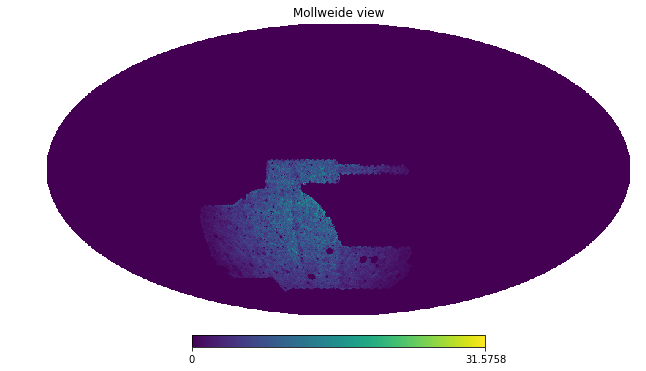

In [22]:
import copy
# weights for the stars.
'''
ratio of galaxy density to stellar density.
So upweight where galaxies are relatively denser and 
downweight where stars are relatively dense

'''

nside = 256

desy3_map = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(ra,dec, nside=nside)

unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
desy3_map[unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix1)))
mas_desy3 = desy3_map!=0.
hp.mollview(desy3_map)



stars_map = np.zeros(hp.nside2npix(nside))

pix1 = convert_to_pix_coord(ras,decs, nside=nside)

unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
stars_map[unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix1)))
hp.mollview(stars_map)

weight_map = copy.copy(stars_map)
weight_map[stars_map!=0.] = desy3_map[stars_map!=0.]/stars_map[stars_map!=0.]

hp.mollview(weight_map)



# assign weights to stars
weight_stars = weight_map[pix1]


# jackknife

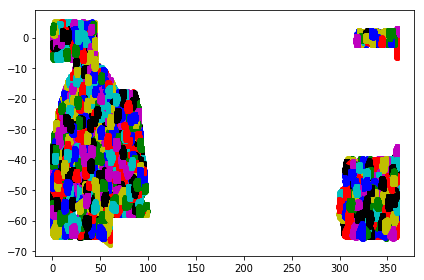

In [31]:
import kmeans_radec
import os
from scipy import spatial
from kmeans_radec import KMeans, kmeans_sample


# INPUT:   ****************************
'''
you might want to use 100 jackknife if you're using
the sumbsampled version of the catalog/
'''
nside = 1024

desy3_map = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(ra,dec, nside=nside)

unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
desy3_map[unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix1)))
mas_desy3 = desy3_map!=0.




n_jck = 1000 #!!!!!!

def IndexToDeclRa(index, nside,ge=False,nest=False):
    theta,phi=hp.pixelfunc.pix2ang(nside ,index,nest)
    if ge:
        r = hp.rotator.Rotator(coord=['G','E'])
        theta, phi = r(theta,phi) 
    return -np.degrees(theta-np.pi/2.),np.degrees(phi)




def jaccknife_regions(ra,dec,number_of_regions,label_jck = None, centers_jck = None, v = False):
    new_cat=np.array(zip(ra, dec))
    A=new_cat[np.random.randint(new_cat.shape[0],size=20000),:]
    
    if not v:
        centers_jck= kmeans_radec.kmeans_sample(A,number_of_regions,maxiter=100,tol=1e-05,verbose=0)
        np.savetxt(label_jck, centers_jck.centers)
        centers_tree = spatial.cKDTree(centers_jck.centers[:,[0,1]])
        _ , hpix= centers_tree.query(np.array(zip(ra,dec)))
        return centers_tree, hpix, centers_jck.centers[:,[0,1]]   
    
    centers_tree = spatial.cKDTree(centers_jck[:,[0,1]])
    _ , hpix= centers_tree.query(np.array(zip(ra,dec)))
    return centers_tree, hpix, centers_jck[:,[0,1]]

# define jackknife regions **********************
mask_jkkk =  (mas_desy3!=0.)
area = np.array(range(hp.nside2npix(nside)))[mask_jkkk]
dech,rah = IndexToDeclRa(area, nside)
   
label_jck= "./centers1000spn.txt"
label_dist= "./dist1000spn.txt"
if  os.path.exists(label_jck):
    centers=np.array(np.loadtxt(label_jck)) 
    centers_tree, hpix, centers = jaccknife_regions(rah,dech,n_jck,label_jck, centers, v = True)
else:
    centers_tree, hpix, centers = jaccknife_regions(rah,dech,n_jck,label_jck)

# plot jackknife regions in case ********************
color_i=[]
for gg in range(1000):
    color_i.append('b')
    color_i.append('g')
    color_i.append('r')
    color_i.append('c')
    color_i.append('m')
    color_i.append('y')
    color_i.append('k')

fig= plt.figure()
ax = fig.add_subplot(111)
for j in range(len(np.unique(hpix))):
    mask2=hpix==j
    plt.plot(rah[mask2], dech[mask2], 'o', ms=4, alpha=1., color=color_i[j])
plt.show()


# jackknife assignment to stars
bbb = np.vstack([np.array(ras).T,
                             np.array(decs).T]).T
from scipy import spatial
from astropy.table import Table
_, hpix_s =  (spatial.cKDTree(centers)).query(bbb)



# jackknife assignment to mastercat
ii=0
bbb = np.vstack([np.array(cat[ii][2]).T,
                             np.array(cat[ii][3]).T]).T



from scipy import spatial
from astropy.table import Table
_, hpp =  (spatial.cKDTree(centers)).query(bbb)
cat[ii][4] = hpp


label_dist= "./dist1000spn.txt"
distance_calc(label_dist,rah,dech,hpix, n_jck, centers)



# Prepare runs

In [ ]:
Nbins = 20

min_theta = 0.1/60.
max_theta = 250./60.
number_of_cores = 64
bin_slope = 0.001


rewrite = False
runs_path = dict()
count = 0

conf = {'nbins': Nbins,
            'min_sep': min_theta,
            'max_sep': max_theta,
            'sep_units': 'degrees',
            'bin_slop': bin_slope,
            'nodes': number_of_cores  # parameter for treecorr
            }


runs_path=dict()
count =0

ii=0
   
name_foder =name_folder_x+'_{0}/'.format(ii)
outp_fold = name_foder+'/pairs/'
name_output  = name_foder+'/y3_'

if not os.path.exists(name_foder):    
    os.mkdir(name_foder)


# p,w,q with and without star weights *********************
arr1 = [w1,q1,p1,w1,q1,p1]
arr2 = [w2,q2,p2,w2,q2,p2]
arrw = [np.ones(len( w2)),np.ones(len( w2)),np.ones(len( w2)),weight_stars,weight_stars,weight_stars]
lb = ['w_','q_','p_','w_sw_','q_sw_','p_sw_']

for k in range(6):
    mute_dict = dict()
    mute_dict['conf'] = conf
    mute_dict['label_dist'] = label_dist
    mute_dict['ra_1'] = cat[0][2]
    mute_dict['dec_1'] =  cat[0][3]
    mute_dict['ra_2'] = ras
    mute_dict['dec_2'] = decs
    mute_dict['hpix1'] = cat[0][4]
    mute_dict['hpix2'] = hpix_s
    mute_dict['w1'] = w
    mute_dict['w2'] = arrw[k]
    mute_dict['g1_1'] = cat[0][0]
    mute_dict['g2_1'] = cat[0][1]
    mute_dict['g1_2'] = arr1[k]
    mute_dict['g2_2'] = arr2[k]
    mute_dict['centers']=centers
    mute_dict['n_jck']= n_jck
    mute_dict['path_pkl'] = name_output+'_'+lb[k]
    mute_dict['outp_fold'] = outp_fold
    mute_dict['label'] = lb[k]

    if not os.path.exists(name_output):
        os.mkdir(name_output)
    path_run  = name_output+'_'+lb[k]
    runs_path[count]=path_run
    save_obj(path_run,mute_dict)
    count+=1



# rho0....rho5: 

arrb1 = [p1,q1,w1,p1,w1,w1]
arrb2 = [p2,q2,w2,p2,w2,w2]


arr1 = [p1,q1,w1,q1,q1,p1]
arr2 = [p2,q2,w2,q2,q2,p2]
arrw = [weight_stars,weight_stars,weight_stars,weight_stars,weight_stars,weight_stars]
lb = ['rho0_','rho1_','rho3_','rho2_','rho4_','rho5_']


for k in range(6):
    mute_dict = dict()
    mute_dict['conf'] = conf
    mute_dict['label_dist'] = label_dist
    mute_dict['ra_1'] = ras
    mute_dict['dec_1'] =  decs
    mute_dict['ra_2'] = ras
    mute_dict['dec_2'] = decs
    mute_dict['hpix1'] = hpix_s
    mute_dict['hpix2'] = hpix_s
    mute_dict['w1'] = arrw[k]
    mute_dict['w2'] = arrw[k]
    mute_dict['g1_1'] = arrb1[k]
    mute_dict['g2_1'] = arrb2[k]
    mute_dict['g1_2'] = arr1[k]
    mute_dict['g2_2'] = arr2[k]
    mute_dict['centers']=centers
    mute_dict['n_jck']= n_jck
    mute_dict['path_pkl'] = name_output+'_'+lb[k]
    mute_dict['outp_fold'] = outp_fold
    mute_dict['label'] = lb[k]

    if not os.path.exists(name_output):
        os.mkdir(name_output)
    path_run  = name_output+'_'+lb[k]
    runs_path[count]=path_run
    save_obj(path_run,mute_dict)
    count+=1




# rho0....rho5 with star weights: 

arrb1 = [p1,q1,w1,p1,w1,w1]
arrb2 = [p2,q2,w2,p2,w2,w2]


arr1 = [p1,q1,w1,q1,q1,p1]
arr2 = [p2,q2,w2,q2,q2,p2]
arrw = [np.ones(len( w2)),np.ones(len( w2)),np.ones(len( w2)),np.ones(len( w2)),np.ones(len( w2)),np.ones(len( w2))]
lb = ['rho0_sw_','rho1_sw_','rho3_sw_','rho2_sw_','rho4_sw_','rho5_sw_']


for k in range(6):
    mute_dict = dict()
    mute_dict['conf'] = conf
    mute_dict['label_dist'] = label_dist
    mute_dict['ra_1'] = ras
    mute_dict['dec_1'] =  decs
    mute_dict['ra_2'] = ras
    mute_dict['dec_2'] = decs
    mute_dict['hpix1'] = hpix_s
    mute_dict['hpix2'] = hpix_s
    mute_dict['w1'] = arrw[k]
    mute_dict['w2'] = arrw[k]
    mute_dict['g1_1'] = arrb1[k]
    mute_dict['g2_1'] = arrb2[k]
    mute_dict['g1_2'] = arr1[k]
    mute_dict['g2_2'] = arr2[k]
    mute_dict['centers']=centers
    mute_dict['n_jck']= n_jck
    mute_dict['path_pkl'] = name_output+'_'+lb[k]
    mute_dict['outp_fold'] = outp_fold
    mute_dict['label'] = lb[k]

    if not os.path.exists(name_output):
        os.mkdir(name_output)
    path_run  = name_output+'_'+lb[k]
    runs_path[count]=path_run
    save_obj(path_run,mute_dict)
    count+=1



print ('done')
save_obj("runs_path_ABE_y3",runs_path)
